In [1]:
!pip install -q torch
!pip install -q darts
!pip install -q torchmetrics

In [41]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries

In [42]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas


import openmeteo_requests

import requests_cache

from retry_requests import retry
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [43]:

def make_dataframe(openmeteo_response):

    hourly = openmeteo_response.Hourly()
    _start = pd.to_datetime(hourly.Time(), unit = "s", utc = True)
    _end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True)
    _delta = pd.Timedelta(seconds = hourly.Interval())

    data = {
        "date": pd.date_range(_start, _end, freq=_delta, inclusive="left"),
        "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction_10m": hourly.Variables(3).ValuesAsNumpy(),
        "wind_gusts_10m": hourly.Variables(4).ValuesAsNumpy(),
    }

    return pd.DataFrame(data).set_index("date")

In [44]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [47.36, 46, 47.26, 46.5],
	"longitude": [8.55, 8.95, 11.39, 11.35],
	"start_date": "2024-01-01",
	"end_date": "2024-03-15",
	"hourly": ["temperature_2m", "surface_pressure", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"]
}
original_data = openmeteo.weather_api(url, params=params)
data = dict(zip(("Zurich", "Lugano", "Innsbruck", "Bolzano"), original_data))
data = pd.concat({key: make_dataframe(val) for key, val in data.items()})

city_codes = {"Zurich": 1, "Lugano": 2, "Innsbruck": 3, "Bolzano": 4}
data['city_code'] = data.index.get_level_values(0).map(city_codes)

In [45]:
original_data = dict(zip(("Zurich", "Lugano", "Innsbruck", "Bolzano"), original_data))
original_data = pd.concat({key: make_dataframe(val) for key, val in original_data.items()})

In [46]:
original_data.loc[('Zurich')]

,temperature_2m,surface_pressure,wind_speed_10m,wind_direction_10m,wind_gusts_10m
date,,,,,
2023-01-01 00:00:00+00:00,8.140000,973.382080,10.308830,245.224884,16.559999
2023-01-01 01:00:00+00:00,8.990001,973.148743,6.130579,183.366394,19.799999
2023-01-01 02:00:00+00:00,7.890000,972.958252,8.121970,192.804260,17.280001
2023-01-01 03:00:00+00:00,8.790000,972.829041,7.993298,172.234924,18.000000
2023-01-01 04:00:00+00:00,8.440001,973.243835,7.594207,185.440247,19.080000
...,...,...,...,...,...
2024-03-15 19:00:00+00:00,7.590000,967.487000,7.127636,224.999893,15.119999
2024-03-15 20:00:00+00:00,9.490001,968.099182,5.351785,227.726379,23.039999
2024-03-15 21:00:00+00:00,8.540000,967.936279,7.280550,188.530685,18.359999


In [47]:
correct = pd.DataFrame()

In [48]:
correct.index = original_data.loc[('Zurich')].index

In [49]:
correct['temperature_2m_zh'] = original_data.loc[('Zurich')].temperature_2m
correct['surface_pressure_zh'] = original_data.loc[('Zurich')].surface_pressure
correct['wind_speed_10m_zh'] = original_data.loc[('Zurich')].wind_speed_10m
correct['wind_direction_10m_zh'] = original_data.loc[('Zurich')].wind_direction_10m
correct['wind_gusts_10m_zh'] = original_data.loc[('Zurich')].wind_gusts_10m

correct['temperature_2m_lu'] = original_data.loc[('Lugano')].temperature_2m
correct['surface_pressure_lu'] = original_data.loc[('Lugano')].surface_pressure
correct['wind_speed_10m_lu'] = original_data.loc[('Lugano')].wind_speed_10m
correct['wind_direction_10m_lu'] = original_data.loc[('Lugano')].wind_direction_10m
correct['wind_gusts_10m_lu'] = original_data.loc[('Lugano')].wind_gusts_10m

correct['temperature_2m_in'] = original_data.loc[('Innsbruck')].temperature_2m
correct['surface_pressure_in'] = original_data.loc[('Innsbruck')].surface_pressure
correct['wind_speed_10m_in'] = original_data.loc[('Innsbruck')].wind_speed_10m
correct['wind_direction_10m_in'] = original_data.loc[('Innsbruck')].wind_direction_10m
correct['wind_gusts_10m_in'] = original_data.loc[('Innsbruck')].wind_gusts_10m

correct['temperature_2m_bo'] = original_data.loc[('Bolzano')].temperature_2m
correct['surface_pressure_bo'] = original_data.loc[('Bolzano')].surface_pressure
correct['wind_speed_10m_bo'] = original_data.loc[('Bolzano')].wind_speed_10m
correct['wind_direction_10m_bo'] = original_data.loc[('Bolzano')].wind_direction_10m
correct['wind_gusts_10m_bo'] = original_data.loc[('Bolzano')].wind_gusts_10m

In [50]:
#Getting 'date' from the Multindex to be used in the future covariates

correct['dayofyear'] = correct.index.get_level_values('date').dayofyear

#sin and cos calculation 

correct['day_sin'] = np.sin(2 * np.pi * correct['dayofyear'] / 365.0)
correct['day_cos'] = np.cos(2 * np.pi * correct['dayofyear'] / 365.0)

In [51]:
originalindex = correct.index

In [52]:
correct.columns

Index(['temperature_2m_zh', 'surface_pressure_zh', 'wind_speed_10m_zh',
       'wind_direction_10m_zh', 'wind_gusts_10m_zh', 'temperature_2m_lu',
       'surface_pressure_lu', 'wind_speed_10m_lu', 'wind_direction_10m_lu',
       'wind_gusts_10m_lu', 'temperature_2m_in', 'surface_pressure_in',
       'wind_speed_10m_in', 'wind_direction_10m_in', 'wind_gusts_10m_in',
       'temperature_2m_bo', 'surface_pressure_bo', 'wind_speed_10m_bo',
       'wind_direction_10m_bo', 'wind_gusts_10m_bo', 'dayofyear', 'day_sin',
       'day_cos'],
      dtype='object')

In [53]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
target_scaler.fit(correct[['surface_pressure_zh']])
scaled_data = pd.DataFrame(scaler.fit_transform(correct), columns=scaler.get_feature_names_out())
scaled_data.index = originalindex

In [54]:
target = scaled_data[['surface_pressure_zh']]
past_cov = scaled_data.drop(columns=['dayofyear', 'day_sin', 'day_cos'])
future_cov = scaled_data[['dayofyear', 'day_sin', 'day_cos']]

In [55]:
from darts import TimeSeries
from darts.models.forecasting.tft_model import TFTModel
from darts.metrics import mse
from darts.metrics import smape, mae
from torchmetrics.regression import MeanAbsoluteError

In [56]:
train_start = '2023-01-01 00:00:00+00:00'
train_end = '2023-10-30 23:00:00+00:00' #70% = 21 days
train_future_end ='2023-10-31 02:00:00+00:00'

val_start = '2023-10-31 00:00:00+00:00'
val_end = '2024-02-15 20:00:00+00:00' 
val_future_end = '2024-02-15 23:00:00+00:00'

test_start = '2024-02-16 00:00:00+00:00'
test_end = '2024-03-15 23:00:00+00:00'

y_train = target.loc[train_start:train_end]
past_cov_train = past_cov.loc[train_start:train_end]
future_cov_train = future_cov.loc[train_start:train_future_end]

y_val = target.loc[val_start:val_end]
past_cov_val = past_cov.loc[val_start:val_end]
future_cov_val = future_cov.loc[val_start:val_future_end]

y_test = target.loc[test_start:test_end]

y_train_backtest = target.loc[train_start:val_end]
past_cov_train_backtest = past_cov.loc[train_start:val_end]
future_cov_train_backtest = future_cov.loc[train_start:val_future_end]


In [57]:
y_train_series = TimeSeries.from_dataframe(y_train)
past_cov_train_series = TimeSeries.from_dataframe(past_cov_train)
future_cov_train_series = TimeSeries.from_dataframe(future_cov_train)

y_val_series = TimeSeries.from_dataframe(y_val)
past_cov_val_series = TimeSeries.from_dataframe(past_cov_val)
future_cov_val_series = TimeSeries.from_dataframe(future_cov_val)

y_test_series = TimeSeries.from_dataframe(y_test)

y_train_backtest_series = TimeSeries.from_dataframe(y_train_backtest)
past_cov_train_backtest_series = TimeSeries.from_dataframe(past_cov_train_backtest)
future_cov_train_backtest_series = TimeSeries.from_dataframe(future_cov_train_backtest)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the 

In [58]:
# TFTModel:
input_chunk_length = 24
output_chunk_length = 3

In [59]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=100,
    min_delta=0.0001,
    mode='min',
)

# use GPU
pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "gpu",
                   "devices": [0]}

# use CPU
#pl_trainer_kwargs={"callbacks": [my_stopper],
                   #"accelerator": "cpu"}

# Advanced tuning
tft = TFTModel(input_chunk_length =input_chunk_length ,
               output_chunk_length = output_chunk_length,
               pl_trainer_kwargs = pl_trainer_kwargs,
               lstm_layers=2,
               num_attention_heads=8,
               dropout=0.2,
               batch_size=16,
               hidden_size=64,
               torch_metrics=MeanAbsoluteError(),
               n_epochs=2,
               # add_encoders=add_encoders
               )

tft.fit(series=y_train_series,
        past_covariates = past_cov_train_series,
        future_covariates = future_cov_train_series,
        val_series=y_val_series,
        val_past_covariates=past_cov_val_series,
        val_future_covariates=future_cov_val_series)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 47.3 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 5.2 K 
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResid

Sanity Checking: |                                                                                | 0/? [00:00…

/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('val_MeanAbsoluteError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |                                                                                       | 0/? [00:00…

/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('train_MeanAbsoluteError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=2` reached.


TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=2, num_attention_heads=8, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=3, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fe9b51057b0>], 'accelerator': 'gpu', 'devices': [0]}, batch_size=16, torch_metrics=MeanAbsoluteError(), n_epochs=2)

In [60]:
##tft = TFTModel(input_chunk_length =input_chunk_length ,                
#               output_chunk_length = output_chunk_length,
#               pl_trainer_kwargs = pl_trainer_kwargs,
#               torch_metrics=MeanAbsoluteError(),
#               n_epochs=50
#               )

In [62]:
preds = tft.predict(n=output_chunk_length,
                   series=y_val_series,
                   past_covariates = past_cov_val_series,
                   future_covariates = future_cov_val_series)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

In [63]:
preds

<TimeSeries (DataArray) (date: 3, component: 1, sample: 1)> Size: 24B
array([[[0.64338238]],

       [[0.59445181]],

       [[0.59545006]]])
Coordinates:
  * date       (date) datetime64[ns] 24B 2024-02-15T21:00:00 ... 2024-02-15T2...
  * component  (component) object 8B 'surface_pressure_zh'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [66]:
from sklearn.preprocessing import MinMaxScaler

# Assuming you have 'scaled_data' DataFrame containing your scaled data

# Example predictions

# Inverse transform predictions using target_scaler
original_preds = target_scaler.inverse_transform(preds.reshape(-1, 1))

print("Original predictions (pressure values):", original_preds.flatten())


Original predictions (pressure values): [970.38307696 967.42996587 967.49021334]


<Axes: xlabel='date'>

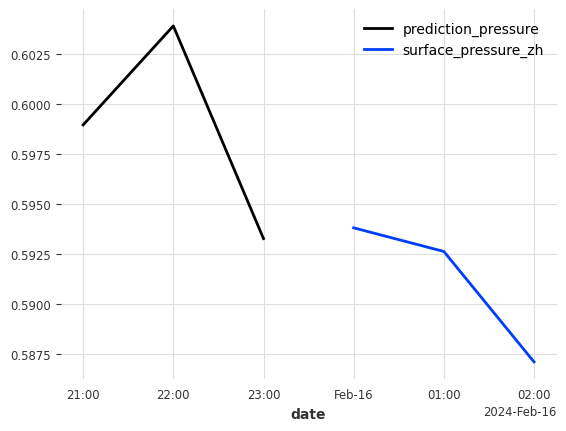

In [124]:
preds.plot(label='prediction_pressure')
y_test_series[:output_chunk_length].plot()

In [125]:
historical_fcast_tft = tft.historical_forecasts(
        series=y_train_backtest_series,
        past_covariates=past_cov_train_backtest_series,
        future_covariates=future_cov_train_backtest_series,
        start=0,
        forecast_horizon=7,
        verbose=False,
        retrain=False
)

`start` value `0` corresponding to timestamp `2023-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2023-01-02 00:00:00. To hide these warnings, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [126]:
historical_fcast_tft.duration,historical_fcast_tft.start_time(), historical_fcast_tft.end_time() 

(Timedelta('409 days 14:00:00'),
 Timestamp('2023-01-02 06:00:00'),
 Timestamp('2024-02-15 20:00:00'))

In [15]:
y_train_backtest_series.filter()

NameError: name 'y_train_backtest_series' is not defined

In [129]:
y_train_backtest_series.duration, y_train_backtest_series.start_time(), y_train_backtest_series.end_time()

(Timedelta('410 days 20:00:00'),
 Timestamp('2023-01-01 00:00:00'),
 Timestamp('2024-02-15 20:00:00'))

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

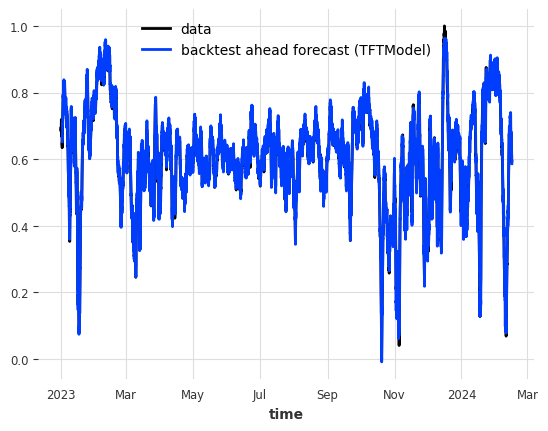

In [130]:
y_train_backtest_series.plot(label="data")
historical_fcast_tft.plot(low_quantile=0.01, high_quantile=0.99,label="backtest ahead forecast (TFTModel)")
print("SMAPE = {:.2f}%".format(smape(target_scaler.inverse_transform(historical_fcast_tft),target_scaler.inverse_transform(y_train_backtest_series))))
print("MAE = {:.2f}".format(mae(historical_fcast_tft, y_train_backtest_series)))

NameError: name 'historical_fcast_tft' is not defined

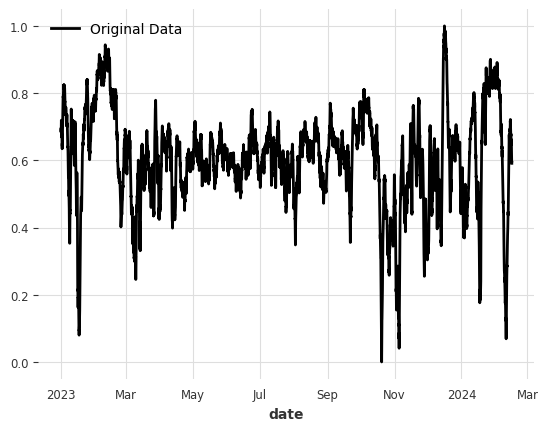

In [105]:
#tft.save('tft_v1_1monthdata_3h')

In [131]:
pred_values = target_scaler.inverse_transform(preds.pd_dataframe())
real_values = target_scaler.inverse_transform(y_test.values)

In [132]:
def smape_function(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    Parameters:
    - actual: array containing actual values
    - predicted: array containing predicted values

    Returns:
    - SMAPE value
    """
    denominator = (np.abs(actual) + np.abs(predicted)) / 2.0
    diff = np.abs(actual - predicted) / denominator
    diff[denominator == 0] = 0.0  # Handle division by zero
    smape_value = np.mean(diff) * 100.0

    return smape_value

In [133]:
smape_function(pred_values, real_values[:output_chunk_length])

0.0469946785095469